# PS5

## Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in [Tomizuka 2009](https://mathcs.holycross.edu/~little/Montserrat1112/envmodbackup/1%252E3013196-1.pdf).

### 1.1
Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [169]:
def twoBoxmodel(w, t, p):
    """
    Defines the differential equations for the two-box system model.
    
    Arguments:
        w: vector ofthe sate variables:
            w = [N_1, N_2]
        t: time
        p: vector of the parameters:
            p = [k_12, k_21, gamma]
    """
    N_1, N_2 = w
    k_12, k_21, gamma = p
    
    # Create f = (N_1, N_2):
    f = [-k_12*N_1 + k_21*N_2 + gamma,
         k_12*N_1-k_21*N_2]
    return f

In [229]:
# Import Global Co2 Emssions from Fossil-Fuel Burning data
fsl_CO2 = pd.read_csv('data_files/global.1751_2008.csv', skiprows = [1], usecols = [0,1])
fsl_CO2 = fsl_CO2.loc[(fsl_CO2['Year"'] > 1985) & (fsl_CO2['Year"'] < 2005)].reset_index(drop=True)
# Convert the values into ppm
fsl_CO2 = fsl_CO2.iloc[:,1]/1000/2.13
fsl_CO2.head()

0    2.633333
1    2.701878
2    2.801878
3    2.858216
4    2.887793
Name: Total carbon emissions from fossil-fuels (million metric tons of C), dtype: float64

In [230]:
# Import Mauna Lao Volcano Observed values
obsv_CO2 = pd.read_csv('data_files/co2_annmean_mlo.csv',usecols = [0,1], comment = '#')
obsv_CO2 = obsv_CO2.loc[(obsv_CO2['year'] > 1985) & (obsv_CO2['year'] < 2005)].reset_index(drop=True)
obsv_CO2.head()

,year,mean
0,1986,347.61
1,1987,349.31
2,1988,351.69
3,1989,353.20
4,1990,354.45


Text(0, 0.5, '$\\gamma$')

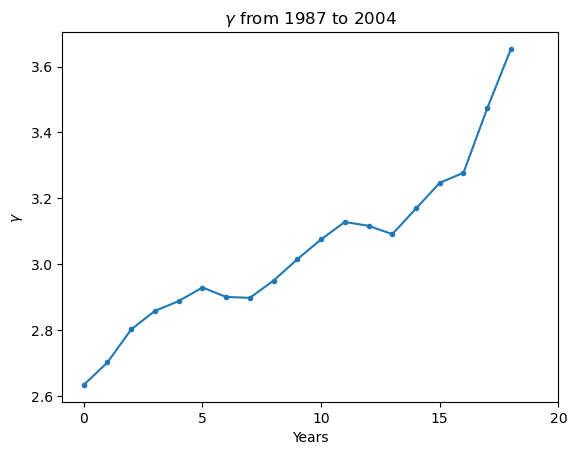

In [239]:
# One tricky problem is that the gamma varies every year,
# so we have to figure out a method to update the gamma
# every step we take
plt.plot(fsl_CO2, marker = '.')
plt.title(r'$\gamma$ from 1987 to 2004')
plt.xticks([0,5,10,15,20])
plt.xlabel('Years')
plt.ylabel(r'$\gamma$')

In [246]:
from scipy.integrate import odeint

# Parameter values
k_12 = 105/740
k_21 = 102/900
gamma = fsl_CO2

# Initial conditions
N_1 = 740/2.13
N_2 = 900/2.13

# Set the time
# The whole time range T defined by 2004-1986+1
# delta t = 1
T = np.arange(0,2004-1986+1)
t = np.array([0,1])

# Make a storage
atm_sol = np.array([N_1])
soc_sol = np.array([N_2])

for i in T:
# Pack up the parameters and initial conditions:
# Notice that we need to update gamma every step(year) we take
    p = [k_12, k_21, gamma[i]]
    w0 = [N_1, N_2]

# Call the ODE solver.
    wsol = odeint(twoBoxmodel, w0, t, args=(p,))
    N_1, N_2 = wsol[1]
# Store the solution pair
    atm_sol = np.append(atm_sol,N_1)
    soc_sol = np.append(soc_sol,N_2)

In [247]:
# Print the solution
year = np.arange(1986,2005,1)
atm_sol = np.delete(atm_sol,-1)
sol_1 = pd.DataFrame({'Year':year,
                      'Atmos CO2 level (ppm)':atm_sol})
sol_1

,Year,Atmos CO2 level (ppm)
0,1986,347.417840
1,1987,348.636200
2,1988,349.907586
3,1989,351.256313
4,1990,352.634151
5,1991,354.015163
6,1992,355.412565
7,1993,356.761410
8,1994,358.093907
9,1995,359.465240


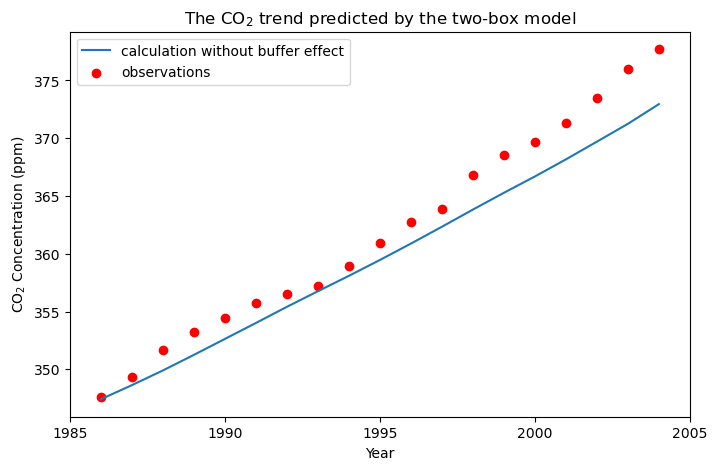

In [251]:
# Plot the solution and observation values
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(year,atm_sol)
ax.scatter(year,obsv_CO2['mean'],c = 'r')
ax.set(title = r'The CO$_2$ trend predicted by the two-box model',
       xlabel = 'Year', ylabel = r'CO$_2$ Concentration (ppm)',
       xticks = np.arange(1985,2010,5))
ax.legend(['calculation without buffer effect','observations'])
plt.show()

### 1.2
Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [281]:
def twoBoxmodel_buffer(w, t, p):
    """
    Defines the differential equations for the two-box system model.
    
    Arguments:
        w: vector ofthe sate variables:
            w = [N_1, N_2, buffer]
        t: time
        p: vector of the parameters:
            p = [k_12, k_21, N_20, gamma]
    """
    N_1, N_2 = w
    k_12, k_21, N_20, xi, gamma = p
    
    # Create f = (N_1, N_2):
    f = [-k_12*N_1 + k_21*(N_20+xi*(N_2-N_20)) + gamma,
         k_12*N_1-k_21*(N_20+xi*(N_2-N_20))]
    return f

In [295]:
# Parameter values
k_12 = 105/740
k_21 = 102/900
N_20 = 821
#xi = 1.5
#xi = 3.69 + 1.86*10**(-2)*N_1 - 1.80*10**(-6)*N_1**2
gamma = fsl_CO2

# Initial conditions
N_1 = 740/2.13
N_2 = 900/2.13
xi = 3.69 + 1.86*10**(-2)*N_1 - 1.80*10**(-6)*N_1**2

# Set the time
# The whole time range T defined by 2004-1986+1
# delta t = 1
T = np.arange(0,2004-1986+1)
t = np.array([0,1])

# Make a storage
atm_sol_buffer = np.array([N_1])
soc_sol_buffer = np.array([N_2])

for i in T:
# Pack up the parameters and initial conditions:
# Notice that we need to update gamma every step(year) we take
    p = [k_12, k_21, N_20, xi,gamma[i]]
    w0 = [N_1, N_2]

# Call the ODE solver.
    wsol = odeint(twoBoxmodel_buffer, w0, t, args=(p,))
    N_1, N_2 = wsol[1]
# Store the solution pair
    atm_sol_buffer = np.append(atm_sol_buffer,N_1)
    soc_sol_buffer = np.append(soc_sol_buffer,N_2)

In [296]:
# Print the solution
atm_sol_buffer = np.delete(atm_sol_buffer,-1)
sol_2 = pd.DataFrame({'Year':year,
                      'Atmos CO2 level (ppm)':atm_sol_buffer})
sol_2

,Year,Atmos CO2 level (ppm)
0,1986,347.417840
1,1987,120.444330
2,1988,58.309920
3,1989,42.641960
4,1990,40.073917
5,1991,41.203240
6,1992,43.403202
7,1993,45.864290
8,1994,48.405165
9,1995,51.019412


### 1.3
Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

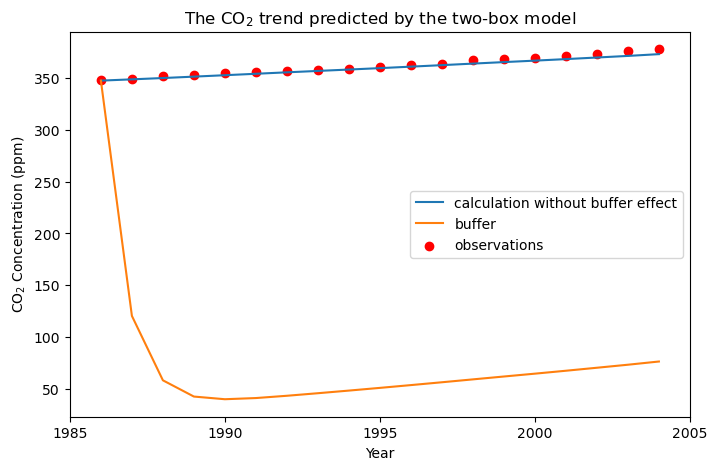

In [297]:
# Plot the solution and observation values
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(year,atm_sol)
ax.plot(year,atm_sol_buffer)
ax.scatter(year,obsv_CO2['mean'],c = 'r')
ax.set(title = r'The CO$_2$ trend predicted by the two-box model',
       xlabel = 'Year', ylabel = r'CO$_2$ Concentration (ppm)',
       xticks = np.arange(1985,2010,5))
ax.legend(['calculation without buffer effect','buffer','observations'])
plt.show()